In [165]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import lightgbm

In [123]:
pd.set_option('display.max_rows', 2000)

In [124]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set_palette("husl", 9)

In [125]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv')
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [126]:
user_engagement_df.user_id.nunique()

8823

There are a total of 8823 users in the dataset.

In [127]:
user_engagement_df.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [128]:
user_engagement_df['time_stamp'] = user_engagement_df['time_stamp'].astype('datetime64')

In [129]:
def to_date_column(dataframe,column:str):
    dataframe["dt_"+column] = pd.to_datetime(dataframe[column], format="%y%m%d%H")
    dataframe[column+"_year"] = dataframe["dt_"+column].dt.year
    dataframe[column+"_month"] = dataframe["dt_"+column].dt.month
    dataframe[column+"_day"] = dataframe["dt_"+column].dt.day
    dataframe[column+"_int_hour"] = dataframe["dt_"+column].dt.hour
    dataframe[column+"_is_weekday"] = dataframe["dt_"+column].dt.dayofweek
    dataframe[column+"_is_weekend"] = dataframe.apply(lambda x: x[column+"_is_weekday"] in [5, 6], axis=1)

In [130]:
to_date_column(user_engagement_df,'time_stamp')

In [131]:
user_engagement_df.head()

,time_stamp,user_id,visited,dt_time_stamp,time_stamp_year,time_stamp_month,time_stamp_day,time_stamp_int_hour,time_stamp_is_weekday,time_stamp_is_weekend
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,2014,4,22,3,1,False
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,2013,11,15,3,4,False
2,2013-11-29 03:45:04,2,1,2013-11-29 03:45:04,2013,11,29,3,4,False
3,2013-12-09 03:45:04,2,1,2013-12-09 03:45:04,2013,12,9,3,0,False
4,2013-12-25 03:45:04,2,1,2013-12-25 03:45:04,2013,12,25,3,2,False


<AxesSubplot:xlabel='time_stamp_int_hour', ylabel='count'>

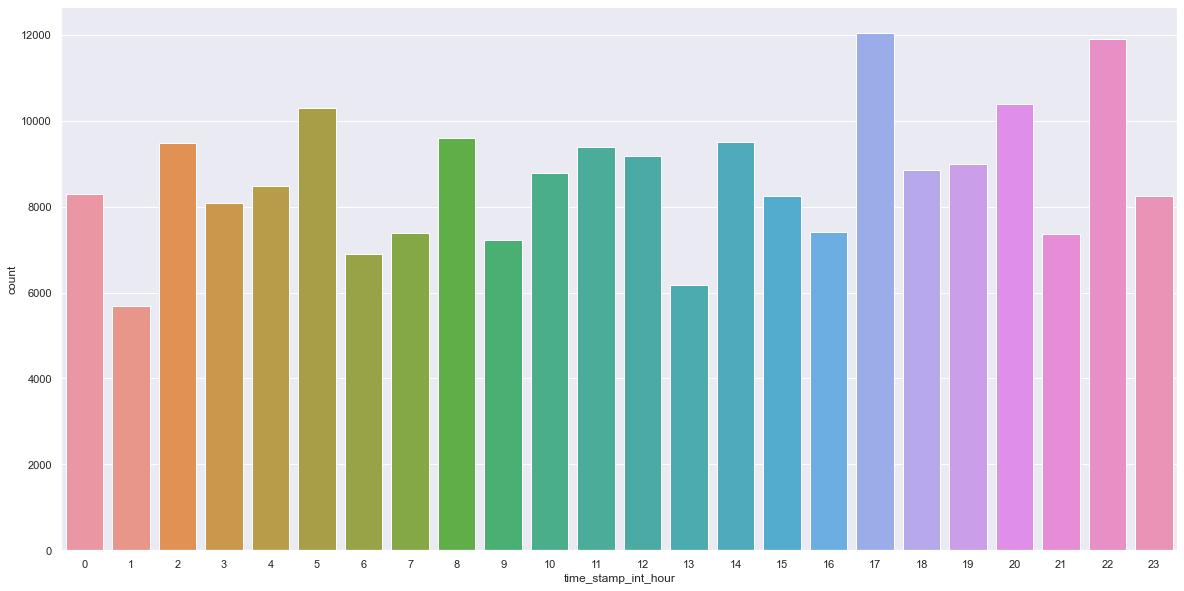

In [132]:
sns.countplot(x = 'time_stamp_int_hour', data = user_engagement_df, )

It appears that most of the logins occur at 17:00 and 22:00.

<AxesSubplot:xlabel='time_stamp_is_weekend', ylabel='count'>

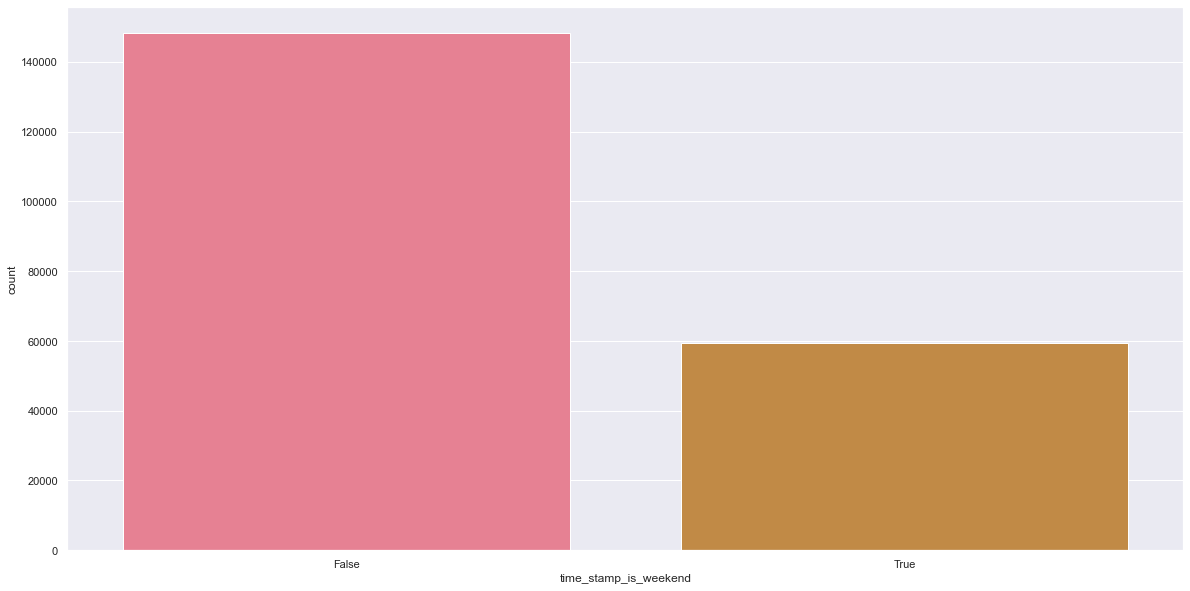

In [133]:
sns.countplot(x = 'time_stamp_is_weekend', data = user_engagement_df, )

Most of the logins are on weekdays.

<AxesSubplot:xlabel='time_stamp_is_weekday', ylabel='count'>

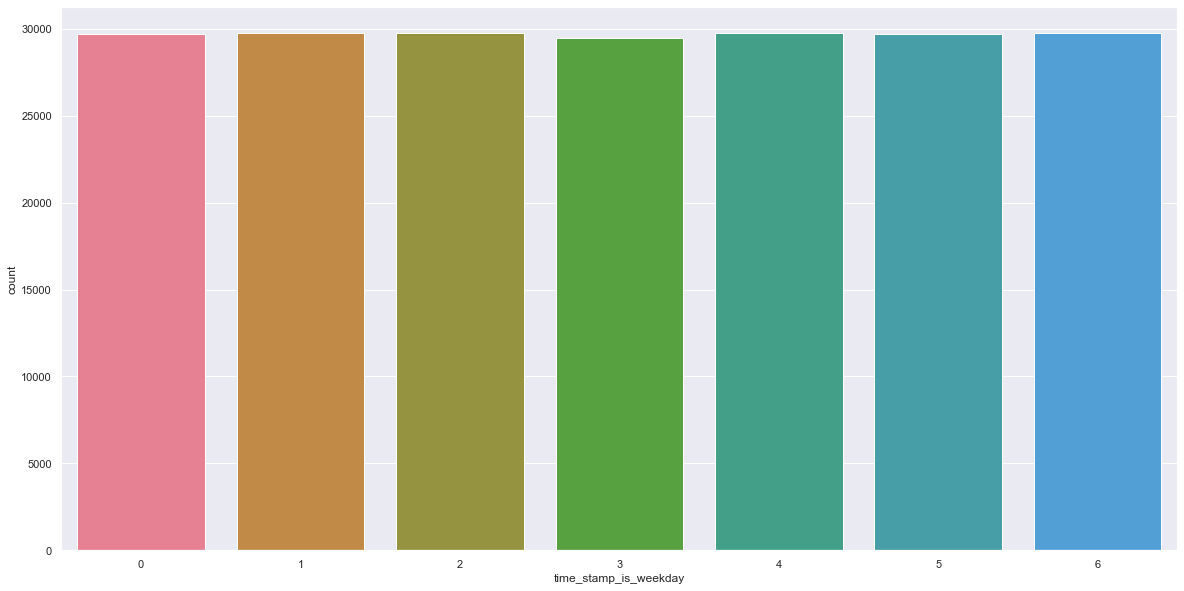

In [134]:
sns.countplot(x = 'time_stamp_is_weekday', data = user_engagement_df, )

The logins on the weekdays show no discernable pattern.

In [135]:
def logins_in_days(df, days=7, logins=3):
    df['date'] = df['time_stamp'].dt.date
    #df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= dt.timedelta(days=days))

In [136]:
adopted_users_df = user_engagement_df.groupby('user_id').apply(logins_in_days)
adopted_users_df.head()

user_id
1    False
2     True
3    False
4    False
5    False
dtype: bool

In [137]:
user_counts = user_engagement_df["user_id"].value_counts()
adopted_users = user_counts[user_counts >= 3]
adopted_users.index

Int64Index([ 3623,   906,  1811,  7590,  8068,  9402,  4022,  3269,  9312,
             7210,
            ...
             9284, 11851,  6808,  9318,  8047,  6090,  8464,  5528,  6900,
             7310],
           dtype='int64', length=2248)

In [138]:
for index, val in adopted_users.iteritems(): 
    user_engagement_df.loc[user_engagement_df['user_id'] == index, 'adopted_user'] = 1
user_engagement_df.head()

,time_stamp,user_id,visited,dt_time_stamp,time_stamp_year,time_stamp_month,time_stamp_day,time_stamp_int_hour,time_stamp_is_weekday,time_stamp_is_weekend,adopted_user
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,2014,4,22,3,1,False,NaN
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,2013,11,15,3,4,False,1.0
2,2013-11-29 03:45:04,2,1,2013-11-29 03:45:04,2013,11,29,3,4,False,1.0
3,2013-12-09 03:45:04,2,1,2013-12-09 03:45:04,2013,12,9,3,0,False,1.0
4,2013-12-25 03:45:04,2,1,2013-12-25 03:45:04,2013,12,25,3,2,False,1.0


In [139]:
user_engagement_df['adopted_user'] = user_engagement_df['adopted_user'].fillna(0)
user_engagement_df.head()

,time_stamp,user_id,visited,dt_time_stamp,time_stamp_year,time_stamp_month,time_stamp_day,time_stamp_int_hour,time_stamp_is_weekday,time_stamp_is_weekend,adopted_user
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,2014,4,22,3,1,False,0.0
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,2013,11,15,3,4,False,1.0
2,2013-11-29 03:45:04,2,1,2013-11-29 03:45:04,2013,11,29,3,4,False,1.0
3,2013-12-09 03:45:04,2,1,2013-12-09 03:45:04,2013,12,9,3,0,False,1.0
4,2013-12-25 03:45:04,2,1,2013-12-25 03:45:04,2013,12,25,3,2,False,1.0


In [140]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [141]:
len(users_df)

12000

In [142]:
duplicateRowsDF = user_engagement_df[user_engagement_df.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [time_stamp, user_id, visited, dt_time_stamp, time_stamp_year, time_stamp_month, time_stamp_day, time_stamp_int_hour, time_stamp_is_weekday, time_stamp_is_weekend, adopted_user]
Index: []


In [143]:
duplicateRowsDF = users_df[users_df.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [object_id, creation_time, name, email, creation_source, last_session_creation_time, opted_in_to_mailing_list, enabled_for_marketing_drip, org_id, invited_by_user_id]
Index: []


In [144]:
users_df.rename(columns={'object_id': 'user_id'}, inplace=True)

In [145]:
df_raw = pd.merge(users_df,user_engagement_df,how='inner',on='user_id')
df_raw.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,dt_time_stamp,time_stamp_year,time_stamp_month,time_stamp_day,time_stamp_int_hour,time_stamp_is_weekday,time_stamp_is_weekend,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1,2014-04-22 03:53:30,2014,4,22,3,1,False,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1,2013-11-15 03:45:04,2013,11,15,3,4,False,1.0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,1,2013-11-29 03:45:04,2013,11,29,3,4,False,1.0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,1,2013-12-09 03:45:04,2013,12,9,3,0,False,1.0
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,1,2013-12-25 03:45:04,2013,12,25,3,2,False,1.0


In [146]:
len(df_raw)

207917

In [147]:
duplicateRowsDF = df_raw[df_raw.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [user_id, creation_time, name, email, creation_source, last_session_creation_time, opted_in_to_mailing_list, enabled_for_marketing_drip, org_id, invited_by_user_id, time_stamp, visited, dt_time_stamp, time_stamp_year, time_stamp_month, time_stamp_day, time_stamp_int_hour, time_stamp_is_weekday, time_stamp_is_weekend, adopted_user]
Index: []


<AxesSubplot:xlabel='creation_source', ylabel='count'>

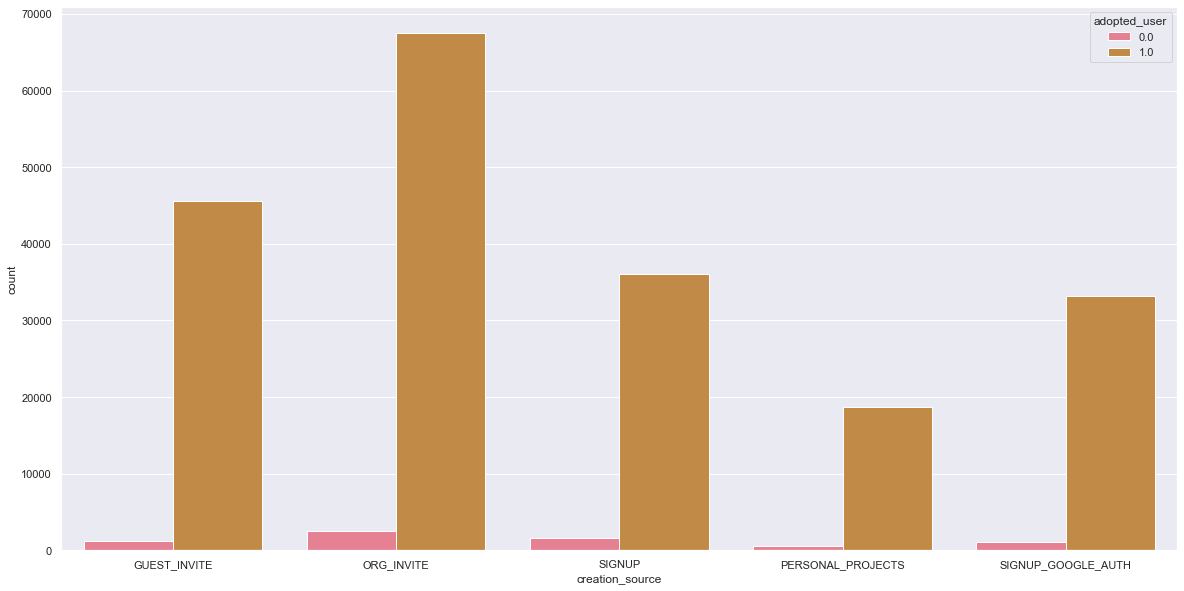

In [148]:
sns.countplot(x='creation_source', data=df_raw, hue='adopted_user')

Most of the adopted users are from the organizational invite.

In [149]:
df_raw.dtypes

user_id                                int64
creation_time                         object
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
time_stamp                    datetime64[ns]
visited                                int64
dt_time_stamp                 datetime64[ns]
time_stamp_year                        int64
time_stamp_month                       int64
time_stamp_day                         int64
time_stamp_int_hour                    int64
time_stamp_is_weekday                  int64
time_stamp_is_weekend                   bool
adopted_user                         float64
dtype: object

In [150]:
df_raw.drop(['user_id','name','email','org_id','invited_by_user_id'],axis=1,inplace=True)
df_raw.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,time_stamp,visited,dt_time_stamp,time_stamp_year,time_stamp_month,time_stamp_day,time_stamp_int_hour,time_stamp_is_weekday,time_stamp_is_weekend,adopted_user
0,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,2014-04-22 03:53:30,1,2014-04-22 03:53:30,2014,4,22,3,1,False,0.0
1,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,2013-11-15 03:45:04,1,2013-11-15 03:45:04,2013,11,15,3,4,False,1.0
2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,2013-11-29 03:45:04,1,2013-11-29 03:45:04,2013,11,29,3,4,False,1.0
3,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,2013-12-09 03:45:04,1,2013-12-09 03:45:04,2013,12,9,3,0,False,1.0
4,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,2013-12-25 03:45:04,1,2013-12-25 03:45:04,2013,12,25,3,2,False,1.0


In [151]:
df_raw['last_session_creation_time'] = df_raw['last_session_creation_time'].astype('datetime64[ns]')
df_raw['creation_time'] = df_raw['creation_time'].astype('datetime64[ns]')
df_raw.dtypes

creation_time                 datetime64[ns]
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
time_stamp                    datetime64[ns]
visited                                int64
dt_time_stamp                 datetime64[ns]
time_stamp_year                        int64
time_stamp_month                       int64
time_stamp_day                         int64
time_stamp_int_hour                    int64
time_stamp_is_weekday                  int64
time_stamp_is_weekend                   bool
adopted_user                         float64
dtype: object

In [152]:
to_date_column(df_raw,'creation_time')
to_date_column(df_raw,'last_session_creation_time')
df_raw.dtypes

creation_time                            datetime64[ns]
creation_source                                  object
last_session_creation_time               datetime64[ns]
opted_in_to_mailing_list                          int64
enabled_for_marketing_drip                        int64
time_stamp                               datetime64[ns]
visited                                           int64
dt_time_stamp                            datetime64[ns]
time_stamp_year                                   int64
time_stamp_month                                  int64
time_stamp_day                                    int64
time_stamp_int_hour                               int64
time_stamp_is_weekday                             int64
time_stamp_is_weekend                              bool
adopted_user                                    float64
dt_creation_time                         datetime64[ns]
creation_time_year                                int64
creation_time_month                             

In [153]:
X = df_raw.drop(['creation_time','last_session_creation_time','time_stamp','dt_time_stamp','dt_creation_time','dt_last_session_creation_time','adopted_user'],axis=1)
y = df_raw['adopted_user']

In [154]:
label_encoder = LabelEncoder()
for x in X.columns:
    label_encoder.fit(X[x])
    X[x] = label_encoder.transform(X[x])

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)

In [166]:
y_train = y_train.to_frame("adopted_user")
y_test = y_test.to_frame("adopted_user")

In [156]:
X_train.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,visited,time_stamp_year,time_stamp_month,time_stamp_day,time_stamp_int_hour,time_stamp_is_weekday,time_stamp_is_weekend,...,creation_time_day,creation_time_int_hour,creation_time_is_weekday,creation_time_is_weekend,last_session_creation_time_year,last_session_creation_time_month,last_session_creation_time_day,last_session_creation_time_int_hour,last_session_creation_time_is_weekday,last_session_creation_time_is_weekend
87297,1,0,0,0,1,11,2,18,1,0,...,0,18,1,0,0,0,0,0,0,0
164741,1,0,0,0,1,5,28,13,5,1,...,15,13,5,1,0,0,0,0,0,0
134021,0,1,0,0,2,1,1,9,6,1,...,15,9,1,0,0,0,0,0,0,0
147280,1,0,0,0,2,2,18,3,2,0,...,14,3,4,0,0,0,0,0,0,0
42655,4,0,0,0,2,3,15,22,2,0,...,7,22,4,0,0,0,0,0,0,0


In [157]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(verbose=True)
clf.fit(X_train, y_train)


y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/krishnasreenivas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


In [158]:
print(clf.coef_)
print(X_train.columns)

[[-1.98858507e-01 -3.72990035e-01 -4.28038969e-02  0.00000000e+00
   2.84085352e+01  2.33667496e+00  6.43752714e-02 -1.19400777e-03
  -1.86536550e-01  8.14710958e-01 -2.87494695e+01 -2.38248437e+00
  -7.60208481e-02 -1.19400777e-03 -1.44892397e-01  7.36254469e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Index(['creation_source', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'visited', 'time_stamp_year',
       'time_stamp_month', 'time_stamp_day', 'time_stamp_int_hour',
       'time_stamp_is_weekday', 'time_stamp_is_weekend', 'creation_time_year',
       'creation_time_month', 'creation_time_day', 'creation_time_int_hour',
       'creation_time_is_weekday', 'creation_time_is_weekend',
       'last_session_creation_time_year', 'last_session_creation_time_month',
       'last_session_creation_time_day', 'last_session_creation_time_int_hour',
       'last_session_creation_time_is_weekday',
       'last_session

In [159]:

pd.DataFrame(zip(X_train.columns, np.transpose(clf.coef_.tolist()[0])), columns=['features', 'coef']).sort_values(by='coef',ascending=False)

,features,coef
4,time_stamp_year,28.408535
5,time_stamp_month,2.336675
9,time_stamp_is_weekend,0.814711
15,creation_time_is_weekend,0.736254
6,time_stamp_day,0.064375
18,last_session_creation_time_day,0.000000
16,last_session_creation_time_year,0.000000
19,last_session_creation_time_int_hour,0.000000
20,last_session_creation_time_is_weekday,0.000000
21,last_session_creation_time_is_weekend,0.000000


As per the logistic regression, time_stamp_year is the most important feature followed by time_stamp_month.

In [160]:
roc_auc_score(y_train, y_train_pred)

0.8150462203925013

In [162]:
roc_auc_score(y_test, y_test_pred)

0.8076300308479238

In [163]:
accuracy_score(y_train, y_train_pred)

0.9782604513361165

In [164]:
accuracy_score(y_test, y_test_pred)

0.977914582531743

Since the dataset is heavily imbalanced, the vanilla logistic regression model outputs 0.97 as accuracy. Since the dataset is imbalanced, using accuracy as a metric is incorrect.

In [167]:
LightGBM = lightgbm.LGBMClassifier(application = 'binary', objective = 'binary', boosting_type = 'dart', metric = 'auc', scale_pos_weight = (len(y_train[y_train['adopted_user'] == 0]) / len(y_train[y_train['adopted_user'] == 1])))

In [168]:
LightGBM.fit(X_train,y_train)

/Users/krishnasreenivas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMClassifier(application='binary', boosting_type='dart', metric='auc',
               objective='binary', scale_pos_weight=0.034826696042843205)

In [169]:
FeatureImportanceDf = pd.DataFrame(LightGBM.feature_importances_,
                                  index = X_train.columns,
                                  columns = ['ImportanceScore']).sort_values('ImportanceScore',ascending=False)
with(pd.option_context('display.max_rows', 100)):
    print(FeatureImportanceDf)

                                       ImportanceScore
time_stamp_month                                   764
creation_time_month                                720
time_stamp_day                                     453
creation_time_day                                  452
creation_time_year                                 175
time_stamp_year                                    172
creation_source                                     70
time_stamp_int_hour                                 57
creation_time_is_weekday                            57
time_stamp_is_weekday                               56
enabled_for_marketing_drip                          10
time_stamp_is_weekend                                9
opted_in_to_mailing_list                             5
visited                                              0
creation_time_int_hour                               0
creation_time_is_weekend                             0
last_session_creation_time_year                      0
last_sessi

In [170]:
columns = list(FeatureImportanceDf[FeatureImportanceDf['ImportanceScore'] == 0].index)
X_train.drop(columns = columns, axis = 1, inplace=True)
X_test.drop(columns = columns, axis = 1, inplace=True)

/Users/krishnasreenivas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [171]:
params = {
    'learning_rate': [0.05,0.1],
    'min_child_weight': [1,3,5,7],
    'min_split_gain': [0.05,0.1,0.3,0.5,0.7,0.9,1.0,5.0],
    'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 3.0, 10.0, 15.0],
    'subsample': [0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.6,0.7,0.8,0.9,1.0],
    'reg_lambda': [0.01,0.05,0.1,0.5,1.0,2.0,3.0],
    'min_data_in_leaf': [30, 45, 60],
    'max_depth': [3,5],
    'num_leaves': [7, 31],
    'early_stopping_rounds':[5]
}

In [172]:
cvset = StratifiedKFold(n_splits=5)
RandomSearch = RandomizedSearchCV(LightGBM, param_distributions=params, n_jobs=20, n_iter=50, cv=cvset, verbose = 3)

In [173]:
RandomSearch.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:   41.6s
[Parallel(n_jobs=20)]: Done 250 out of 250 | elapsed:  1.7min finished
/Users/krishnasreenivas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/krishnasreenivas/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/krishnasreenivas/opt/anaconda3/lib/python3.8/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(application='binary',
                                            boosting_type='dart', metric='auc',
                                            objective='binary',
                                            scale_pos_weight=0.034826696042843205),
                   n_iter=50, n_jobs=20,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'early_stopping_rounds': [5],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'min_data_in_leaf': [30, 45, 60],
                                        'min_split_gain': [0.05, 0.1, 0.3, 0.5,
   

In [174]:
labels = RandomSearch.classes_
y_train_pred = RandomSearch.predict_proba(X_train)
y_train_pred_df = pd.DataFrame(y_train_pred, columns = labels)
y_train_pred_df.head()

,0.0,1.0
0,0.004282,0.995718
1,0.025248,0.974752
2,0.023999,0.976001
3,0.045622,0.954378
4,0.005332,0.994668


In [175]:
y_test_pred = RandomSearch.predict_proba(X_test)
y_test_pred_df = pd.DataFrame(y_test_pred, columns = labels)
y_test_pred_df.head()

,0.0,1.0
0,0.005292,0.994708
1,0.002703,0.997297
2,0.057465,0.942535
3,0.021558,0.978442
4,0.010738,0.989262


In [176]:
roc_auc_score(y_train['adopted_user'].values, y_train_pred_df[1].values)

0.991183311126057

In [177]:
roc_auc_score(y_test['adopted_user'].values, y_test_pred_df[1].values)

0.9903643265145791

As we can see, LightGBM has better ROC score as compared to the Logistic Regression.